In [1]:
from TraGT.load_data import load_data, load_data_long,CustomDataset,adj_list_to_adj_matrix
import torch
from torch_geometric.data import Data
from TraGT.seq_models import TransformerModel
from TraGT.graph_models import Graph_Transformer
from TraGT.fusion_model import FusionModel
import torch.optim as optim
import torch.nn as nn
from datetime import datetime
import os
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

data_name='bbbp'

In [2]:
train_data, train_labels, test_data, test_labels = load_data_long(data_name, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_dim_train = train_data['features'][0].size(-1)
input_dim_test = test_data['features'][0].size(-1)


adj_matrices_train = [adj_list_to_adj_matrix(adj_list) for adj_list in train_data['adj_lists']]
adj_matrices_test = [adj_list_to_adj_matrix(adj_list) for adj_list in test_data['adj_lists']]


data_list_train = [Data(x=torch.tensor(features, dtype=torch.float),
                        edge_index=torch.nonzero(adj_matrix, as_tuple=False).t().contiguous(),
                        y=torch.tensor(label, dtype=torch.float))
                    for features, adj_matrix, label in zip(train_data['features'], adj_matrices_train, train_labels)]
data_list_test = [Data(x=torch.tensor(features, dtype=torch.float),
                                edge_index=torch.nonzero(adj_matrix, as_tuple=False).t().contiguous(),
                                y=torch.tensor(label, dtype=torch.float))
                            for features, adj_matrix, label in zip(test_data['features'], adj_matrices_test, test_labels)]

train_dataset = CustomDataset(data_list_train, train_data['sequence'])
test_dataset = CustomDataset(data_list_test, test_data['sequence'])
    

[23:55:04] WARNING: not removing hydrogen atom without neighbors
[23:55:05] WARNING: not removing hydrogen atom without neighbors
[23:55:05] WARNING: not removing hydrogen atom without neighbors
[23:55:05] WARNING: not removing hydrogen atom without neighbors
[23:55:05] WARNING: not removing hydrogen atom without neighbors
[23:55:05] WARNING: not removing hydrogen atom without neighbors
[23:55:05] WARNING: not removing hydrogen atom without neighbors
[23:55:05] WARNING: not removing hydrogen atom without neighbors
[23:55:06] WARNING: not removing hydrogen atom without neighbors
[23:55:06] WARNING: not removing hydrogen atom without neighbors
[23:55:06] WARNING: not removing hydrogen atom without neighbors
[23:55:06] WARNING: not removing hydrogen atom without neighbors
[23:55:06] WARNING: not removing hydrogen atom without neighbors
[23:55:06] WARNING: not removing hydrogen atom without neighbors
[23:55:06] WARNING: not removing hydrogen atom without neighbors
[23:55:06] WARNING: not r

In [3]:
import torch
vocab_size = 100
d_model = 100
nhead = 4
num_encoder_layers = 3
dim_feedforward = 512
max_length = 100
batch_size = 1
num_epochs = 100
model_path = 'saved_models/bbbp_2024-05-01_15-49-53/test_best_model_90.674.pth'

graph_model = Graph_Transformer(in_channels=input_dim_train, hidden_channels=64, out_channels=1, heads=4).to(device)

sequence_model = TransformerModel(vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward).to(device)

fusion_model = FusionModel(graph_model, sequence_model).to(device)

# Load the state dict into the model
fusion_model.load_state_dict(torch.load(model_path))


c:\Python312\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [19]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import torch

# Variables for best metrics
best_train_accuracy = 0.0
best_test_accuracy = 0.0

# Lists to store features and labels for t-SNE visualization
tsne_train_features = []  # Features for training set
tsne_train_labels = []  # Labels for training set
tsne_test_features = []  # Features for testing set
tsne_test_labels = []  # Labels for testing set

optimizer = optim.Adam(fusion_model.parameters(), lr=0.001,weight_decay=5e-4)  # Adam optimizer
criterion = nn.BCEWithLogitsLoss()


# Testing loop
total_correct = 0
total_samples = 0
true_labels_test = []
pred_probs_test = []    
for data_batch in test_dataset:
    graph_data_batch = data_batch[0]
    sequence_inputs = data_batch[1].to(device)                                                      
    sequence_targets = graph_data_batch.y
    
    output= fusion_model(sequence_inputs)
    binary_predictions = (output >= 0.5).float()
    sequence_targets = sequence_targets.unsqueeze(0)
# Compute epoch test accuracy
epoch_test_accuracy = (total_correct / total_samples) * 100
print(f"Epoch Testing Accuracy: {epoch_test_accuracy:.4f}")

# Concatenate features and labels for t-SNE visualization
test_features = np.concatenate(tsne_test_features, axis=0)  # Test features
test_labels = np.concatenate(tsne_test_labels, axis=0)  # Test labels

# Define TP, TN, FP, FN in the test set
test_predictions = (test_features >= 0.5).astype(int)  # Binary predictions
tp_indices = np.where((test_predictions == 1) & (test_labels == 1))[0]
tn_indices = np.where((test_predictions == 0) & (test_labels == 0))[0]
fp_indices = np.where((test_predictions == 1) & (test_labels == 0))[0]
fn_indices = np.where((test_predictions == 0) & (test_labels == 1))[0]

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)  # Reduce to 2D
tsne_results = tsne.fit_transform(test_features)  # Apply t-SNE to test set

# Create scatter plot with different colors for TP, TN, FP, FN
plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[tp_indices, 0], tsne_results[tp_indices, 1], c='blue', label='True Positive (TP)', alpha=0.7, s=30)
plt.scatter(tsne_results[tn_indices, 0], tsne_results[tn_indices, 1], c='orange', label='True Negative (TN)', alpha=0.7, s=30)
plt.scatter(tsne_results[fp_indices, 0], tsne_results[fp_indices, 1], c='red', label='False Positive (FP)', alpha=0.7, s=30)
plt.scatter(tsne_results[fn_indices, 0], tsne_results[fn_indices, 1], c='green', label='False Negative (FN)', alpha=0.7, s=30)

plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Model Predictions")
plt.legend()  # Add a legend for clarity
plt.show()  # Display the plot

Epoch 1/100, Epoch Accuracy: 86.9433


ZeroDivisionError: division by zero

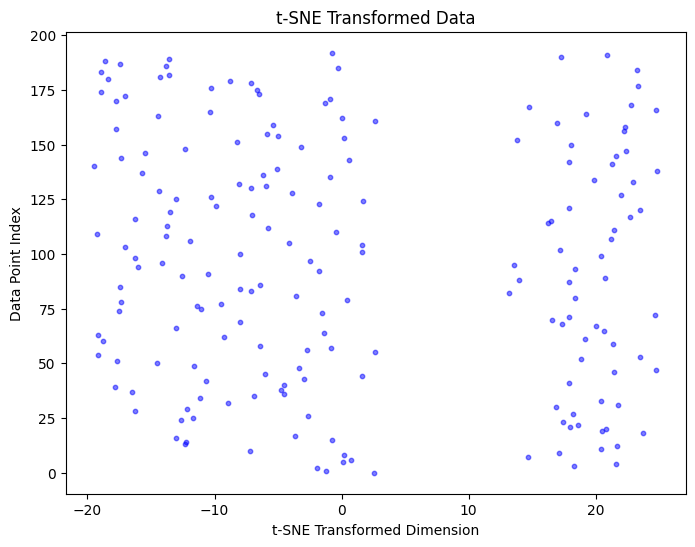

In [9]:
# Plot the t-SNE transformed data
plt.figure(figsize=(8, 6))
plt.scatter(outputs_test_1d, range(len(outputs_test_1d)), s=10, c='b', alpha=0.5)
plt.xlabel('t-SNE Transformed Dimension')
plt.ylabel('Data Point Index')
plt.title('t-SNE Transformed Data')
plt.show()